<a href="https://colab.research.google.com/github/gamesMum/IntelImageClassification_BertSch/blob/master/Intel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The Zodiac Chinese Challenge**

## **Prepare Tha Data**

In [0]:
#Download data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "rashasalim" # username from the json file
os.environ['KAGGLE_KEY'] = "eacad49a0c7d1afc1988a7907a39dca8" # key from the json file
!kaggle datasets download -d puneet6060/intel-image-classification # api copied from kaggle

 96% 333M/346M [00:06<00:00, 33.8MB/s]
100% 346M/346M [00:06<00:00, 52.3MB/s]


- Unzip the file:



In [0]:
#unzip the folder downloaded from kaggle
!unzip intel-image-classification.zip

Archive:  intel-image-classification.zip
  inflating: seg_pred/seg_pred/10004.jpg  
  inflating: seg_pred/seg_pred/10005.jpg  
  inflating: seg_pred/seg_pred/10012.jpg  
  inflating: seg_pred/seg_pred/10013.jpg  
  inflating: seg_pred/seg_pred/10017.jpg  
  inflating: seg_pred/seg_pred/10021.jpg  
  inflating: seg_pred/seg_pred/1003.jpg  
  inflating: seg_pred/seg_pred/10034.jpg  
  inflating: seg_pred/seg_pred/10038.jpg  
  inflating: seg_pred/seg_pred/10040.jpg  
  inflating: seg_pred/seg_pred/10043.jpg  
  inflating: seg_pred/seg_pred/10045.jpg  
  inflating: seg_pred/seg_pred/10047.jpg  
  inflating: seg_pred/seg_pred/10048.jpg  
  inflating: seg_pred/seg_pred/10052.jpg  
  inflating: seg_pred/seg_pred/10054.jpg  
  inflating: seg_pred/seg_pred/10059.jpg  
  inflating: seg_pred/seg_pred/10060.jpg  
  inflating: seg_pred/seg_pred/10066.jpg  
  inflating: seg_pred/seg_pred/10069.jpg  
  inflating: seg_pred/seg_pred/10073.jpg  
  inflating: seg_pred/seg_pred/10079.jpg  
  inflating: s

- Use nonechuck lobrary to use only the goog image files

In [0]:
#Download nonchuks library to remove corrupted images
#!pip install nonechucks

- import the necessary libraries

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

import matplotlib.pyplot as plt

#import nonechucks as nc
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Define transforms, rezise, rotate slightly, preform horizontal flip

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
data_dir = 'signs'

batch_size = 60
valid_size = 0.2

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((250, 250)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((250, 250)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('seg_train/seg_train', transform=train_transforms)
test_data = datasets.ImageFolder('seg_test/seg_test', transform=test_transforms)
#obtain trainig indicies that will be used as validation
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indicies[split:], indicies[:split]
#Define samplers for obtaining the training and validation data
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

print('batch_size: ', batch_size)
print('length of train dataset: ', len(train_data))
print('length of test dataset: ',len(test_data))
#print('length of valid dataset: ',len(valid_data))
# specify the image classes
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

batch_size:  60
length of train dataset:  14034
length of test dataset:  3000


### Visualize a Batch of Training Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


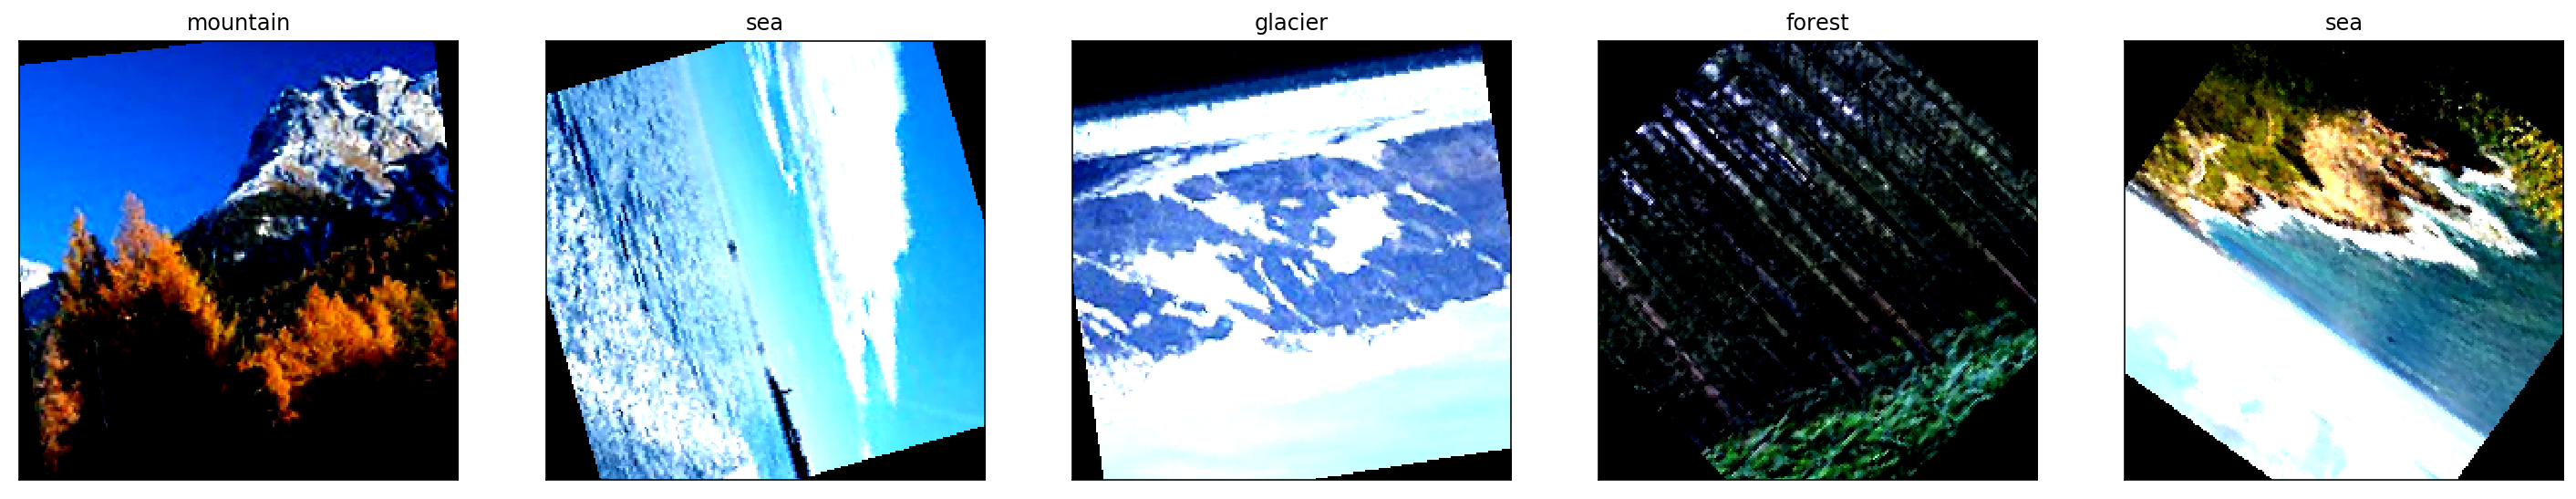

In [0]:
def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

#get one batch of training images
dataiter = iter(train_loader) #now contains the first batch
images, labels = dataiter.next() #images=the first batch of images, labels= the first batch of labels
images = images.numpy() #convert the images to display them

#plot the imahes in the batch along with the corresponding labels
fig = plt.figure(figsize=(25,6))
#display 8 images
for idx in np.arange(5):
  ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[]) #(rows, cols, index, .., ..)
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])



# **Implementing Transfer Learning**
- Importing densnet model


In [0]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

- Stop Autograd for the model, since it is already trained and we don't want any recalculating
- Build our classifier with 6 prdiction classes

In [0]:
for param in model.parameters():
  param.requires_grad=False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
if train_on_gpu:
  model.cuda()

Define the optimizer and the error function

In [0]:
import torch.optim as optim
#the loss function
criterion = nn.NLLLoss()

#the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.03)

# **Training**

In [0]:
# number of epochs to train the model
import numpy as np
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_intel_image_classifier.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.505644 	Validation Loss: 0.454679
Validation loss decreased (inf --> 0.454679).  Saving model ...
Epoch: 2 	Training Loss: 0.487869 	Validation Loss: 0.492448
Epoch: 3 	Training Loss: 0.477780 	Validation Loss: 0.447452
Validation loss decreased (0.454679 --> 0.447452).  Saving model ...
Epoch: 4 	Training Loss: 0.471018 	Validation Loss: 0.423979
Validation loss decreased (0.447452 --> 0.423979).  Saving model ...
Epoch: 5 	Training Loss: 0.462324 	Validation Loss: 0.408639
Validation loss decreased (0.423979 --> 0.408639).  Saving model ...


In [0]:
model.load_state_dict(torch.load('model_intel_image_classifier.pt'))


<All keys matched successfully>

# **Test our model**

In [0]:
#initialize the test loss
test_loss = 0.0

class_correct = list(0. for i in range(6))
class_total = list (0. for i in range(6))

#set the model to test and validation mode (no gradient descent needed)
model.eval()

for data, target in test_loader:
  #move the tensor to GPU ig available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  #forward pass: compute prediction output by passing the first batch of test data
  output = model(data)
  #calculate the batch size
  loss = criterion(output, target)
  #update the test loss
  test_loss += loss.item()*data.size(0)
  #convert output probabilities to output class
  _, pred = torch.max(output, 1)
  #compare the prediction to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  #conveert to numpy array and remove the extra dimention and get only the result
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i] #get the corresponding label from the object
    class_correct[label] += correct[i].item()
    class_total[label] += 1
  
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
  if class_total[i] > 0:
     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
   



Test Loss: 0.398400

Test Accuracy of buildings: 82% (362/437)
Test Accuracy of forest: 95% (453/474)
Test Accuracy of glacier: 79% (438/553)
Test Accuracy of mountain: 69% (363/525)
Test Accuracy of   sea: 94% (484/510)
Test Accuracy of street: 92% (462/501)

Test Accuracy (Overall): 85% (2562/3000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

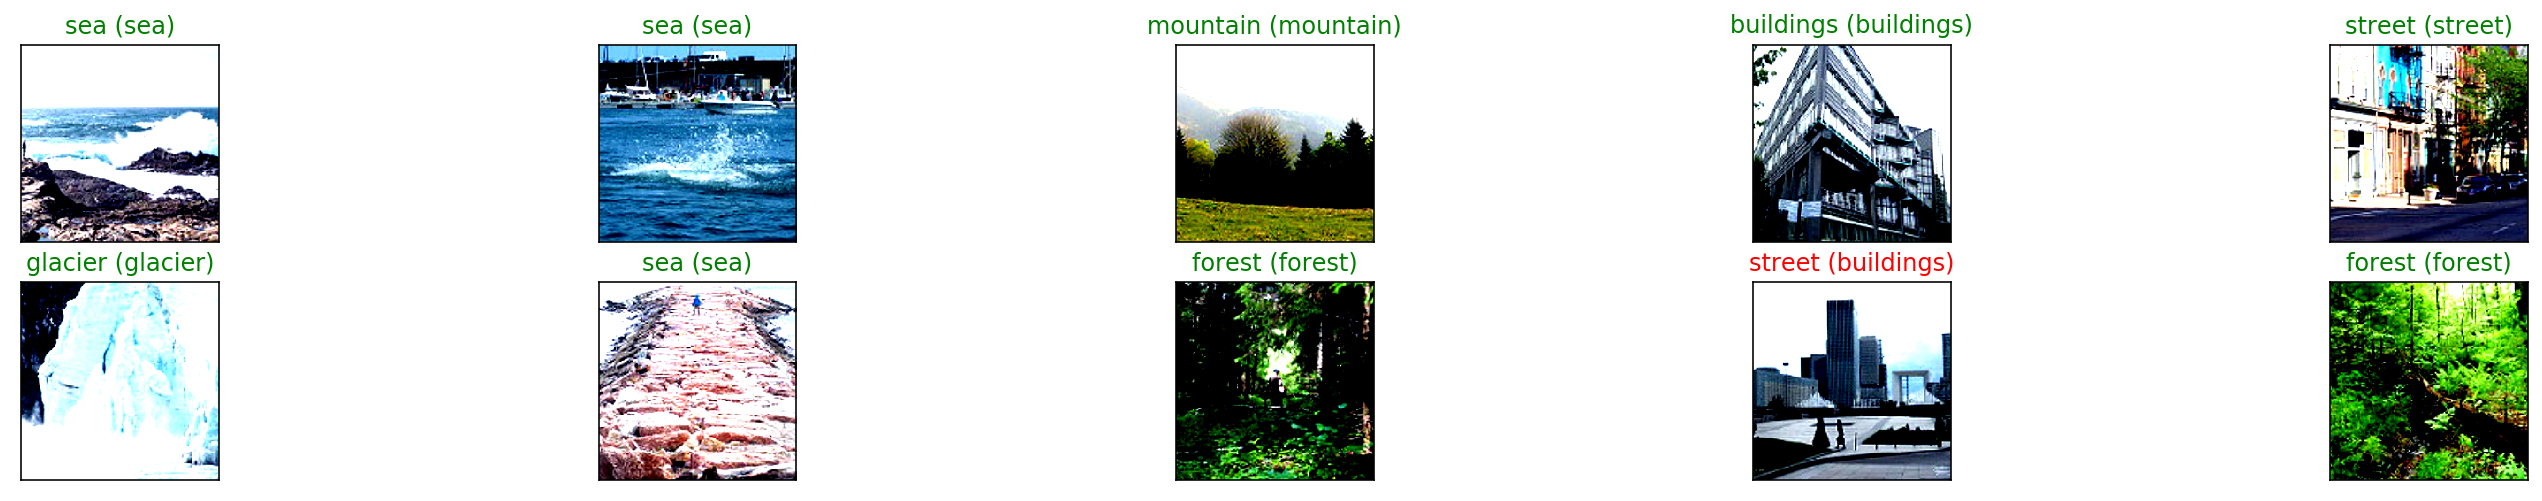

In [0]:
#Visualizing a sample tested of data
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

#Move model inputs to cuda
if train_on_gpu:
  images = images.cuda()

#get sample outputs
output = model(images)
#convert probabilties to prediction class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))